***************************************************

**Definitions and Imports:**

In [1]:
####################################
## DO NOT EDIT THIS CODE SECTION
import numpy as np
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from scipy.signal import correlate, find_peaks, lfilter, freqz, resample
from scipy.linalg import solve_toeplitz
from IPython.display import Audio
from IPython.display import display
from pydub import AudioSegment
from math import pi

##additional imports for metrics
import torch
import torchmetrics
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from torchmetrics.functional import signal_noise_ratio
# For displaying interactive plots in the notebook
%matplotlib widget
####################################

c:\Users\idan.pog\AppData\Local\anaconda3\envs\speech\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


**Useful functions:**

In [2]:
def basic_plot(x, y, xlabel='', ylabel='', title='', grid=True):
    fig = plt.figure()
    line, = plt.plot(x, y)
    y_range = np.max(y)-np.min(y)
    plt.axis([x[0], x[x.size-1], np.min(y)-0.1*y_range, np.max(y)+0.1*y_range])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if(grid):
        plt.grid()
    plt.title(title)
    plt.locator_params(axis='x',tight='true')

def create_time_vector(vector_length: int, sampling_freq: int, start_time: float=0) -> np.ndarray:
    dt = 1/sampling_freq
    return np.arange(start=0, stop=vector_length, step=1)*dt + start_time

def create_freq_vector(signal_length: int, sampling_freq: int, only_positive_half: bool=True) -> np.ndarray:
    fvec = np.arange(0,signal_length)*sampling_freq/signal_length
    if only_positive_half:
        return fvec[:signal_length//2]
    else:
        return fvec

In [3]:
####################################
## DO NOT EDIT THIS CODE SECTION
def read_wav_file(filename: str) -> (int, np.ndarray):
    Fs, signal = read(filename)
    signal = signal.astype(np.float32)
    signal = signal/(2**15)
    return Fs, signal

def write_wav_file(filename: str, sampling_rate: int, signal: np.ndarray):
    signal = signal*(2**15)
    signal = signal.astype(np.int16)    
    write(filename, sampling_rate, signal)

def lpc(x: np.ndarray, p: int) -> np.ndarray:
    n = len(x)
    # Compute autocorrelation vector or matrix
    nextpow2 = 2**(2*n-1).bit_length()
    x_pad = np.pad(array=x, pad_width=(0, nextpow2-n))
    X = np.fft.fft(x_pad)
    R = np.fft.ifft(np.abs(X)**2)
    R = R/n # Biased autocorrelation estimate
    a = np.real(solve_toeplitz(R[0:p],-R[1:(p+1)]))
    a = np.insert(a,0,1)
    return a
    
def plot_pitch(signal: np.ndarray, pitch_vec: np.ndarray, sampling_frequency: int, frame_length: int):
    stvec = create_time_vector(signal.size, sampling_frequency)
    ptvec = np.arange(frame_length//2,signal.size,frame_length)/sampling_frequency
    pitch_vec_hz = np.zeros(pitch_vec.size)
    pitch_vec_hz[pitch_vec != 0] = sampling_frequency/pitch_vec[pitch_vec != 0]
    # plot the results
    fig = plt.figure()

    plt.subplot(211)
    plt.plot(stvec,signal)
    plt.xlabel('Time [Sec]')
    plt.ylabel('Amplitude [Volt]')
    plt.title('Speech Signal')

    plt.subplot(212)
    plt.stem(ptvec,pitch_vec_hz)
    plt.xlabel('Time [Sec]')
    plt.ylabel('Frequency [Hz]')
    plt.title('Pitch Frequency values')

    plt.tight_layout()

def plot_frame_and_filter_spectrum(fvec: np.ndarray, frameSpec_dB: np.ndarray, filterSpec_dB: np.ndarray, filterOrder: int):
    basic_plot(fvec, frameSpec_dB, 'Frequency [Hz]', 'Amplitude [dB]', f'Spectrum of voiced frame and spectrum of predictor filter of order {filterOrder}')
    plt.plot(fvec, filterSpec_dB)
    y_max = np.max([np.max(frameSpec_dB), np.max(filterSpec_dB)])
    y_min = np.min([np.min(frameSpec_dB), np.min(filterSpec_dB)])
    y_range = y_max-y_min
    _,_,_,_ = plt.axis((fvec[0], fvec[fvec.size-1], y_min-0.1*y_range, y_max+0.1*y_range))         
    

def create_signals_for_check(signal: np.ndarray) -> (np.ndarray, np.ndarray, np.ndarray):
    frame_len = 256
    reminder_samp = signal.size%frame_len
    if(reminder_samp > 0):
        pad_num = (frame_len-reminder_samp) # number of zeros for padding
        clean = np.pad(array=signal, pad_width=(0, pad_num))
    else:
        clean = signal      

    # (1) ennode and decode the signal
    N,p,lp,e = encoder(signal)
    reconstructed = decoder(N, p, lp, e)

    # (2) create a broken signal
    noisy = clean + np.sqrt(4*10e-6)*np.random.randn(clean.size)
    frames_num = noisy.size//frame_len
    noisy_frames = np.reshape(a=noisy, newshape=(frames_num, frame_len)) #Each 256 slice is a row   
    noisy_frames[np.arange(4,frames_num,8),:] = 0
    noisy_frames[np.arange(5,frames_num,8),:] = 0
    noisy_frames[np.arange(6,frames_num,8),:] = 0
    noisy_frames[np.arange(7,frames_num,8),:] = 0

    broken = noisy_frames.flatten()
    
    return clean, reconstructed, broken  

def PESQ_quality_check(original_signal:np.ndarray,distorted_signal:np.ndarray,fs:int,frame_len:int,) -> float:
    ### both the original and the reconstructed must be of the size n*frame_len where n is a natural number
    original_signal_interpolated = resample(original_signal, int(original_signal.size*2))
    distorted_signal_interpolated = resample(distorted_signal, int(distorted_signal.size*2))
    fs = fs*2
    N = int(original_signal_interpolated.size//frame_len)
    original_tensor = torch.from_numpy(original_signal_interpolated)
    distorted_tensor = torch.from_numpy(distorted_signal_interpolated)
    pesq_loss = perceptual_evaluation_speech_quality(original_tensor,distorted_tensor,fs,"wb")

    return pesq_loss.item()

def SegSNR_quality_check(original_signal:np.ndarray,distorted_signal:np.ndarray,fs:int,frame_len:int,) -> float:
    ### both the original and the reconstructed must be of the size n*frame_len where n is a natural number
    N = int(original_signal.size//frame_len)
    noise_signal = distorted_signal-original_signal
    original_tensor = torch.from_numpy(original_signal)
    distorted_tensor = torch.from_numpy(distorted_signal)
  
    pesq_loss = perceptual_evaluation_speech_quality(original_tensor,distorted_tensor,fs,"nb")
    
    SNRseg = np.zeros(original_signal.size)
    original_signal_reshaped = original_signal.reshape((N,frame_len))
    noise_signal_reshaped = noise_signal.reshape((N,frame_len))
    for i in range(N):
        P_original = sum(original_signal_reshaped[i,:] ** 2)
        P_noise = sum(noise_signal_reshaped[i,:] ** 2)
        SNRseg[i] = 10*np.log10(P_original/P_noise)
    segmental_snr_value = sum(SNRseg)/N

    return segmental_snr_value        
####################################

************************************************************

## Question 14

### A

According to your ID numbers, load the chosen speech file.  
Pad the signal with zeros so it will contain an integer number of frames.  
Re-define the 'voiced' and 'unvoiced' frames, the same way you did in the last HW.

In [4]:
id_digit = 5 # insert your ID digit

# load speech signal
speechfilename = '../SpeechSignalFiles/speech'+str(id_digit)+'.wav'
fs, speech_signal = read_wav_file(speechfilename)

# Pad the signal with zeros
frameLen = 256 
pad_size = frameLen - (speech_signal.size % frameLen)
speech_signal_padded = np.pad(speech_signal, (0, pad_size), 'constant')

# re-define the voiced and unvoiced exaple frames frm last meeting
voiced_frame_index = int(34)
voiced_example_frame = speech_signal_padded[(voiced_frame_index*frameLen):((voiced_frame_index+1)*frameLen)]

unvoiced_frame_index = int(2)
unvoiced_example_frame = speech_signal_padded[(unvoiced_frame_index*frameLen):((unvoiced_frame_index+1)*frameLen)]

### B
Write a loop that will apply 'vu_classify' function, frame-by-frame, on the whole signal.  
plot the signal and the pitch values using the 'plot_pitch' function.

In [5]:
def zero_cross(frame: np.ndarray) -> int:
    # Initialize zero crossings counter
    sign = np.sign(frame)
    zero_crossings = 0
    for i in range(1, len(frame)):
        zero_crossings += 0.5*np.abs(sign[i]-sign[i-1])

    return zero_crossings

    
def vu_classify(frame: np.ndarray, sampling_freq: int) -> bool:
    N = len(frame)
    assert N == 256
    avg_energy = np.mean(frame**2)
    if(avg_energy < 1e-5):
        res = False
    else:
        # Condition 1 - Check zero crossing
        cond1 = zero_cross(frame) > N / 3
        # Condition 2 - Check energy
        cond2 = avg_energy < 0.01 * np.abs(frame).max()
        # Condition 3 - Check whether highest local peak is out of pitch range     
        pitch_f_max = 400 # [Hz]  according to pitch frequencies range
        pitch_f_min = 50 # [Hz]  according to pitch frequencies range
        pitch_range_min_index = sampling_freq/pitch_f_max
        pitch_range_max_index = sampling_freq/pitch_f_min

        frame_ac = correlate(frame, frame)[(frame.size-1):] # get lags from zero to end
        peaks_indexes, _ = find_peaks(frame_ac)
        max_peak_index = peaks_indexes[np.argmax(frame_ac[peaks_indexes])]
        cond3 =  max_peak_index > pitch_range_max_index or max_peak_index < pitch_range_min_index
        # Condition 4 - Check if main peak is meaningful
        cond4 = (frame_ac[max_peak_index]) / (frame_ac[0]) < 0.35
        # Check voiced/unvoiced
        res = (int(cond1)+int(cond2)+int(cond3)+int(cond4)) < 2
    
    return bool(res)

def pitch_detect_corr(signal: np.ndarray, sampling_freq: int) -> int:
    # Define the pitch range for human voice
    min_pitch_freq = 50
    max_pitch_freq = 400

    # Compute autocorrelation of the signal, focusing on the second half
    autocorr_signal = correlate(signal, signal)[len(signal):]

    # Identify peaks with a minimum distance to filter out closely spaced harmonics
    peaks, _ = find_peaks(autocorr_signal, distance=min_pitch_freq)

    # If not enough peaks found, return 0 indicating no pitch detected
    if len(peaks) < 2:
        return 0

    # Initialize pitch period with the first peak by default
    pitch_period = peaks[0] + 1

    # Iterate over peaks to find the first one within the specified pitch range
    for peak in peaks:
        pitch_freq = sampling_freq / (peak + 1)
        if min_pitch_freq <= pitch_freq <= max_pitch_freq:
            pitch_period = peak + 1
            break

    # Verify if the selected pitch period corresponds to a frequency within the human voice range
    if min_pitch_freq <= sampling_freq / pitch_period <= max_pitch_freq:
        return pitch_period
    else:
        return 0

def create_time_vector(vector_length: int, sampling_freq: int, start_time: float=0) -> np.ndarray:
    dt = 1/sampling_freq
    return np.arange(start=0, stop=vector_length, step=1)*dt + start_time


In [6]:
frames = speech_signal_padded.reshape(-1, frameLen)
frequencies = []
for frame in frames:
    is_voiced = vu_classify(frame, fs)
    if is_voiced:
        pitch_period = pitch_detect_corr(frame, fs)
        pitch_freq = fs / pitch_period
    else:
        pitch_freq = 0
    frequencies.append(pitch_freq)

frequencies = np.array(frequencies)


### C

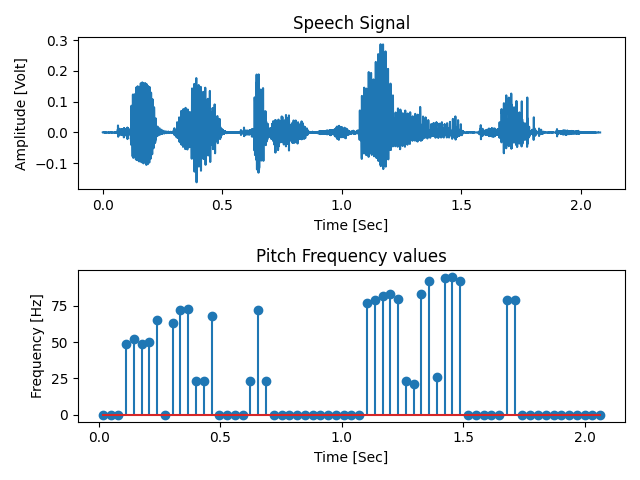

In [7]:
plot_pitch(speech_signal_padded, frequencies, fs, frameLen)

************************************************************

## Question 15

Copy your implementation of the function 'residual_energy' (from the previous parts).

In [8]:
def residual_energy(signal: np.ndarray, FIR_coeffs: np.ndarray) -> int:
    # Compute the prediction error
    prediction_error = signal - lfilter(FIR_coeffs, 1, signal)
    return np.mean(prediction_error**2)

Calculate the lpc coefficients using 'lpc' function.  
Calculate the residual error using the function above.

In [9]:
a = lpc(voiced_example_frame, 10)
e = residual_energy(voiced_example_frame, a)
print(f'The prediction filter coefficients are:')
print(a)
print(f'The prediction error is: {e}')

The prediction filter coefficients are:
[ 1.         -1.62640239  1.38745408 -1.22759853  1.47481158 -1.395741
  0.96795113 -0.77702523  0.78629371 -0.3725756   0.03030473]
The prediction error is: 0.0015518194213751167


Plot the spectrum of the frame, along with the spectrum of the lpc filter using the function 'plot_frame_and_filter_spectrum'.

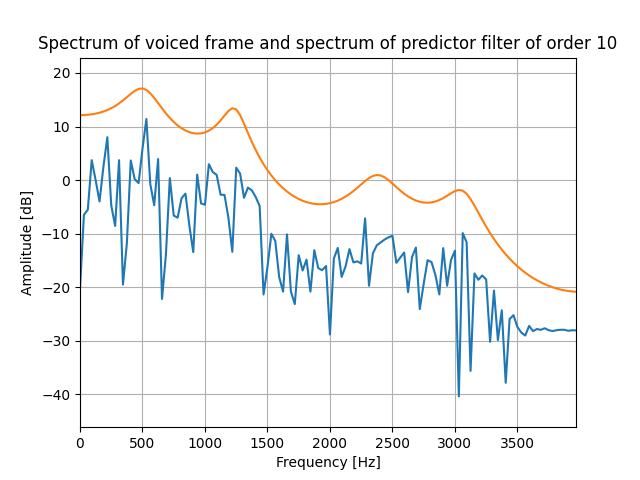

In [10]:
fvec = create_freq_vector(frameLen, fs, only_positive_half=True)

_,H = freqz([1], a, frameLen//2)
H_dB = 20*np.log10(np.abs(H))

voiced_example_frame_F_dB = 20*np.log10(np.abs(np.fft.fft(voiced_example_frame))[:frameLen//2])

plot_frame_and_filter_spectrum(fvec, voiced_example_frame_F_dB, H_dB, 10)

*************************************************************

## Section 17.2

Repeat last section with other 'p' values, according to the booklet.

In [12]:
def prev_section(p):
    a = lpc(voiced_example_frame, p)
    e = residual_energy(voiced_example_frame, a)
    print(f'The prediction error is: {e}')
    fvec = create_freq_vector(frameLen, fs, only_positive_half=True)
    _,H = freqz([1], a, frameLen//2)
    H_dB = 20*np.log10(np.abs(H))
    voiced_example_frame_F_dB = 20*np.log10(np.abs(np.fft.fft(voiced_example_frame))[:frameLen//2])
    plot_frame_and_filter_spectrum(fvec, voiced_example_frame_F_dB, H_dB, p)


The prediction error is: 0.0014639700773256405


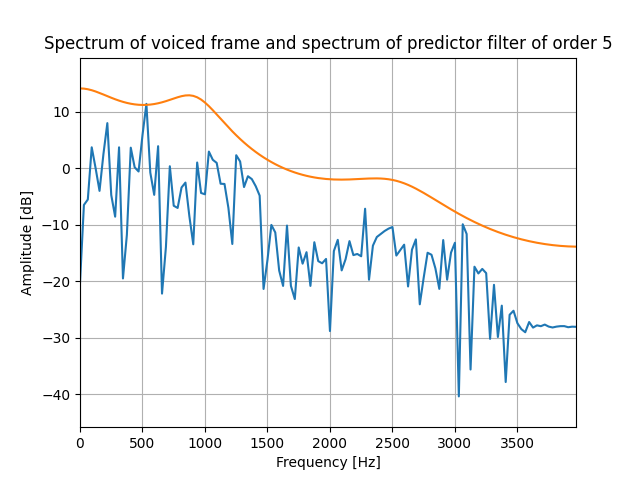

In [13]:
prev_section(5)

The prediction error is: 0.0015807147059338892


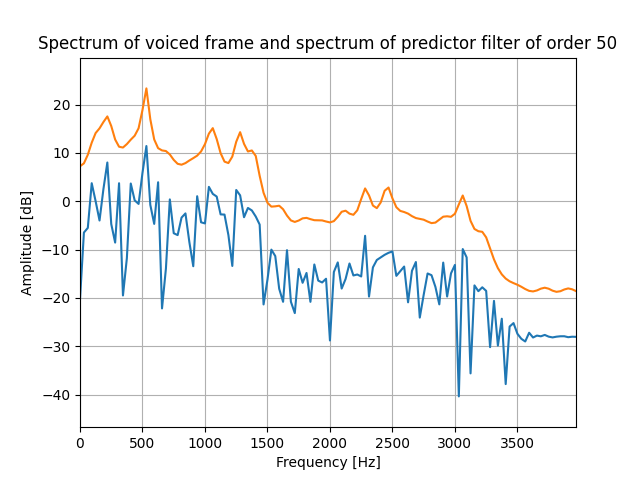

In [14]:
prev_section(50)

************************************************************

## Question 18

Complete the code for the encoder function:

In [15]:
def encoder(signal: np.ndarray) -> (int,np.ndarray,np.ndarray,np.ndarray):
    frame_len = 256
    sampling_freq = 8000    
    LPCorder = 10
    
    # Pad signal with zeros to contain an integer number of frames
    reminder_samp = signal.size%frame_len
    if(reminder_samp > 0):
        pad_num = (frame_len-reminder_samp) # number of zeros for padding
        signal_padded = np.pad(array=signal, pad_width=(0, pad_num))
    else:
        signal_padded = signal           
    
    # Divide the signals to frames
    speech_framed = np.reshape(a=signal_padded, newshape=(signal_padded.size//frame_len, frame_len)) #Each 256 slice is a row    
    
    # Encoder's variables init:
    ##### complete the dimensions ###
    N = len(speech_framed)                   # N is frames_num
    vu_flag = np.zeros(N)   # representing all frames 
    p = np.zeros(N)         # pitch duration for all frames. unvoiced frames are set to 0 pitch values. voiced frames are represented by the *index value* of the pitch (not in Hz)
    lp = np.zeros((LPCorder + 1, N)) # estimated LPC filter's coeffs for all frames
    e = np.zeros(N)         # the square root of the residual energies for all frames
    
    # Encoding process
    for i in range(N): # for each frame
        vu_flag[i] = vu_classify(speech_framed[i], sampling_freq)
        if(vu_flag[i]):
            p[i] = pitch_detect_corr(speech_framed[i], sampling_freq)
        
        lp[:,i] = lpc(speech_framed[i], LPCorder) # estimate the transfer function of the mouth
        e[i] = np.sqrt(residual_energy(speech_framed[i], lp[:, i])) # average energy using residual_energy function

    return (N,p,lp,e)

Run the encoder function on the original signal (not the padded version) to see that it is working:

In [16]:
N,p,lp,e = encoder(speech_signal)

*************************************************************

## Section 18.2

Copy your implementation of the function 'generate_impulse_train_frame' (from the perliminary report).

In [17]:
def generate_impulse_train_frame(frame_len: int, pitch_period: int, reminder_from_last_frame: int) -> (np.ndarray, int):
    first_sample_index_current_frame = (pitch_period - reminder_from_last_frame) % pitch_period
    frame = np.zeros(frame_len)
    for i in np.arange(first_sample_index_current_frame,frame_len,pitch_period):
        frame[i] = 1
    reminder = frame_len - i
    return frame, reminder

Complete the code for the decoder function:

In [ ]:
def decoder(N: int, p: np.ndarray ,lp: np.ndarray, e: np.ndarray) -> (np.ndarray):
    frame_len = 256
    estimated_frames = np.zeros((N, frame_len))  # representation of the synthesized frames of the decoded signal as a matrix (according to the number of frames)
    rem_last_frame = 0 # init of the the reminder-index (the gap from the end of the last frame to the location of the last impulse in the last frame)
    final_cond = np.zeros(...) # according to question 4 in the preliminary questions section in the booklet

    # Decoding process
    for i in range(N):   # for each frame
        # create exitation signal according to u/v decision
        if p[i] == 0: # unvoiced    
            excitation_frame = np.random.randn(frame_len) # white noise
            rem_last_frame = 0
        else: # voiced
            excitation_frame, rem_next_frame = generate_impulse_train_frame(frame_len, p[i], rem_last_frame) # impulse train
            rem_last_frame = ...

        # normalize the excitation signal and amplify it with the gain value. 
        # *DO NOT* forget to use square root of 'normalization_energy' in order to normalize the excitation signal
        normalization_energy = np.sum(excitation_frame**2)/frame_len
        excitation_frame_normalized = ... 
        excitation_frame_amplified = excitation_frame_normalized * ...
        
        # filter the exitation signal with the LPC coefficients, this time use it as an 'all-pole' filter
        estimated_frames[i,:], final_cond = lfilter(..., ..., ..., zi=final_cond)

    # concatenate all frames to a 1-dimentional signal
    return estimated_frames.flatten()

Run the decoder to get a synthesized version of the signal:

In [ ]:
estimated_signal = decoder(...)

Plot the original and the synthesized signal (you can remove the padded section from 'estimated_signal' so both vectors will have the same size):

Play the two audio files and compare how they sound:

Save sythesized signal to file.

In [ ]:
destinationfilename = 'speech'+str(id_digit)+'_synthesized.wav'
write_wav_file(destinationfilename, fs, estimated_signal)